# Neural Network Linear Regression on House Prices

- Dataset about house sales in King County, Washington State, USA. It has data about houses sold between May 2014 and May 2015;
- Dataset has 21613 instances and 21 features. 20 independent features and 1 dependent feature describing the house price ('price');
- Much collinearity found between independent features and few collinearity between independent and the dependent feature;
- Two test cases: (1) dataset filtered according to correlation between variables; (2) full dataset with all features, except for the useless ones (id and date);
- One fully connected neural network regression model built for each test case;
- Regression models have their predictions evaluated visually and using statistical metrics, such as R2 score.
- Dataset used: https://www.kaggle.com/datasets/shivachandel/kc-house-data


--- 

Dataset features description:

1. id: a notation for a house;
2. date: date house was sold;
3. price: house price is the prediction target;
4. bedrooms: number of bedrooms per house;
5. bathrooms: number of bathrooms per bedrooms;
6. sqftliving: square footage of the house;
7. sqftlot: square footage of the lot;
8. floors: total floors (levels) in house;
9. waterfront: house has a view to a waterfront (1 if yes and 0 if not);
10. view: number of times the house has been viewed;
11. condition: how good the house condition is (overall). 1 indicates worn out property and 5 excellent;
12. grade: overall grade given to the house, based on King County's grading system. 1 poor, 13 excellent;
13. sqftabove: square footage of house apart from basement;
14. sqftbasement: square footage of the basement;
15. yrbuilt: year when house was built;
16. yrrenovated: year when house was renovated;
17. zipcode: address zip code;
18. lat: latitude coordinate;
19. long: longitude coordinate;
20. sqftliving15: house area in 2015 (implies some renovations). This might or might not have affected the lotsize area;
21. sqftlot15: lot size area in 2015 (implies some renovations).

---

## Data Exploration

By loading and printing our dataset, we can see that we have 21 features and 21613 instances. One of the features is the response one, 'price'.

There is an ID feature ('id') that does not have any usage for our analysis since it is just a random identifier. There is also a date ('date') feature that goes only from 2014 to 2015. We can remove the date feature as no significant house price change related to time would happen in such a short period of time in the US.

There are a lot of different features referring to area footage of the house. They probably have high correlation.

"bedrooms", "bathrooms", "floors", "views", "condition" and "grade" are going to be interpreted as numerical discrete variables. They are a count with ordered and well-defined intervals between possible values, i.e., a house with "bedrooms" = 3 indeed has 3 times the amount of bedrooms of a house with "bedrooms" = 1. So, they are not treated as categorical variables.

"waterfront" is a binary variable and will be treated as a categorical one. However, binary variables are already one-hot encoded by default.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


house_df = pd.read_csv('/content/kc-house-data.csv')
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


We can use Pandas' functions `describe` and `info` to further explore our data.

From `info` we get that no null values are present in our version of the data, all columns have the same non-null count as the number of instances.

From `describe` we get that our features are not standardized. They have very different means and standard deviations, so we will have to at least rescale them. House price has a very high standard deviation and a very high magnitude (max - min), meaning that houses can have very different prices.

In [ ]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
house_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Taking a look at the correlation matrix for our dataset, we confirm our suspicion that house footage variables are highly correlated. We will keep "sqft_living" for having the highest correlation with the response variable. 

Another reason for keeping "sqft_living" is because it also has high correlation with all other footage variables. It already carries much of their information in itself.

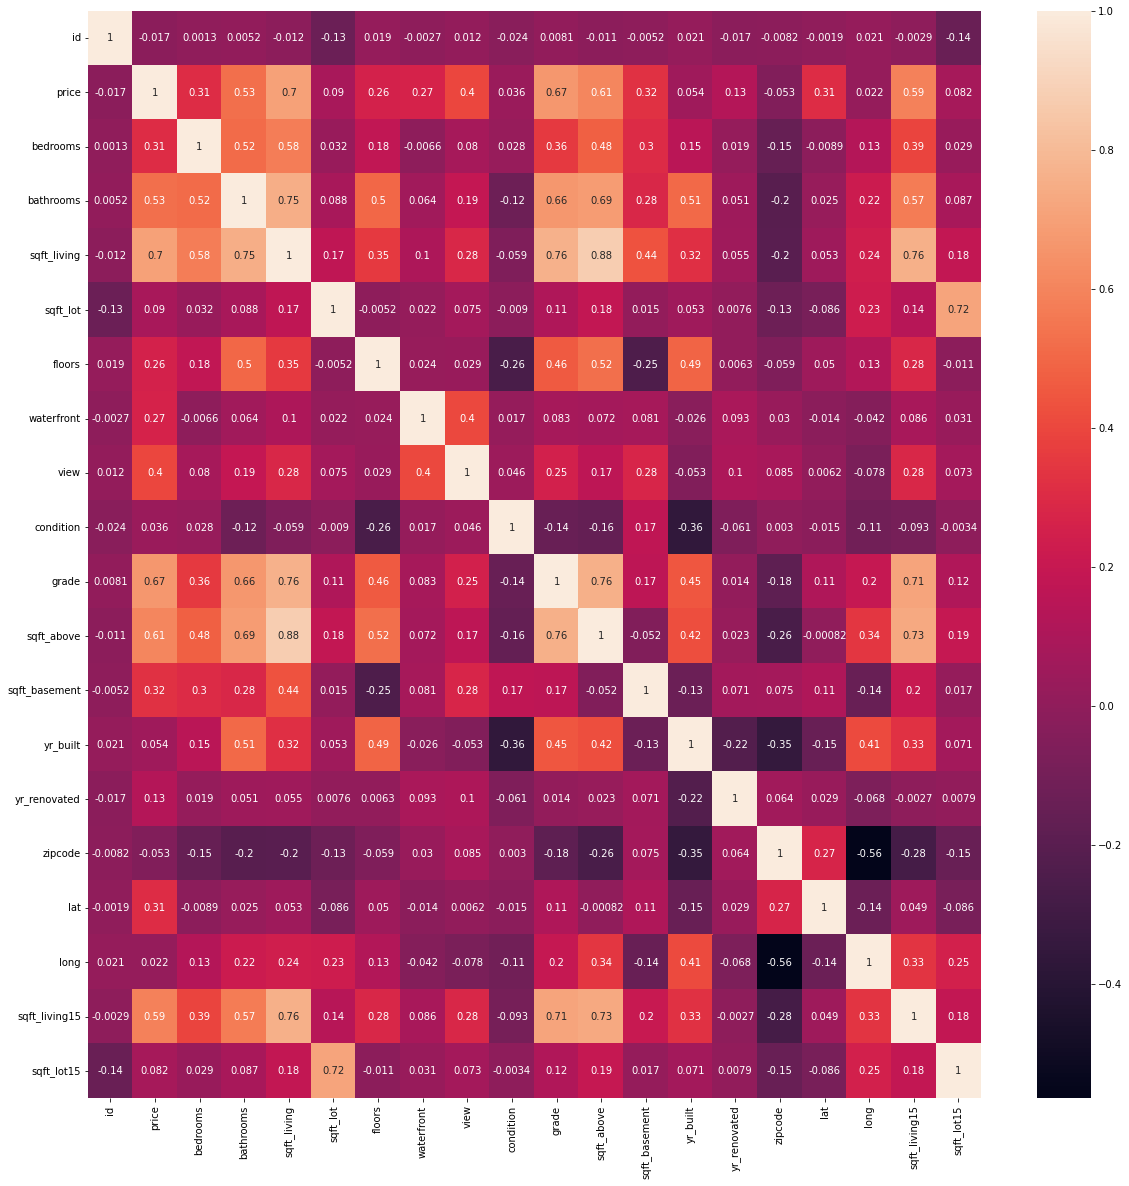

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(house_df.corr(), annot=True)
plt.show()

In the grid below with histograms for each feature, we can see the response feature 'price' being unbalanced. Very few houses have prices above 300.000. 

Ordinary least squares linear regression assumes that prediction errors are stable, following a normal distribution. If the response feature has so much positive skew as we are seeing, its predictions are not going to meet that assumption. There are many ways to remove skew from a variable, one of them is to make a natural log transform on the values, as we do later.

In linear regression with mean squared error, making the response feature normally distributed will also help the model converge faster. Error correction is easier to perform when error variance is smaller.

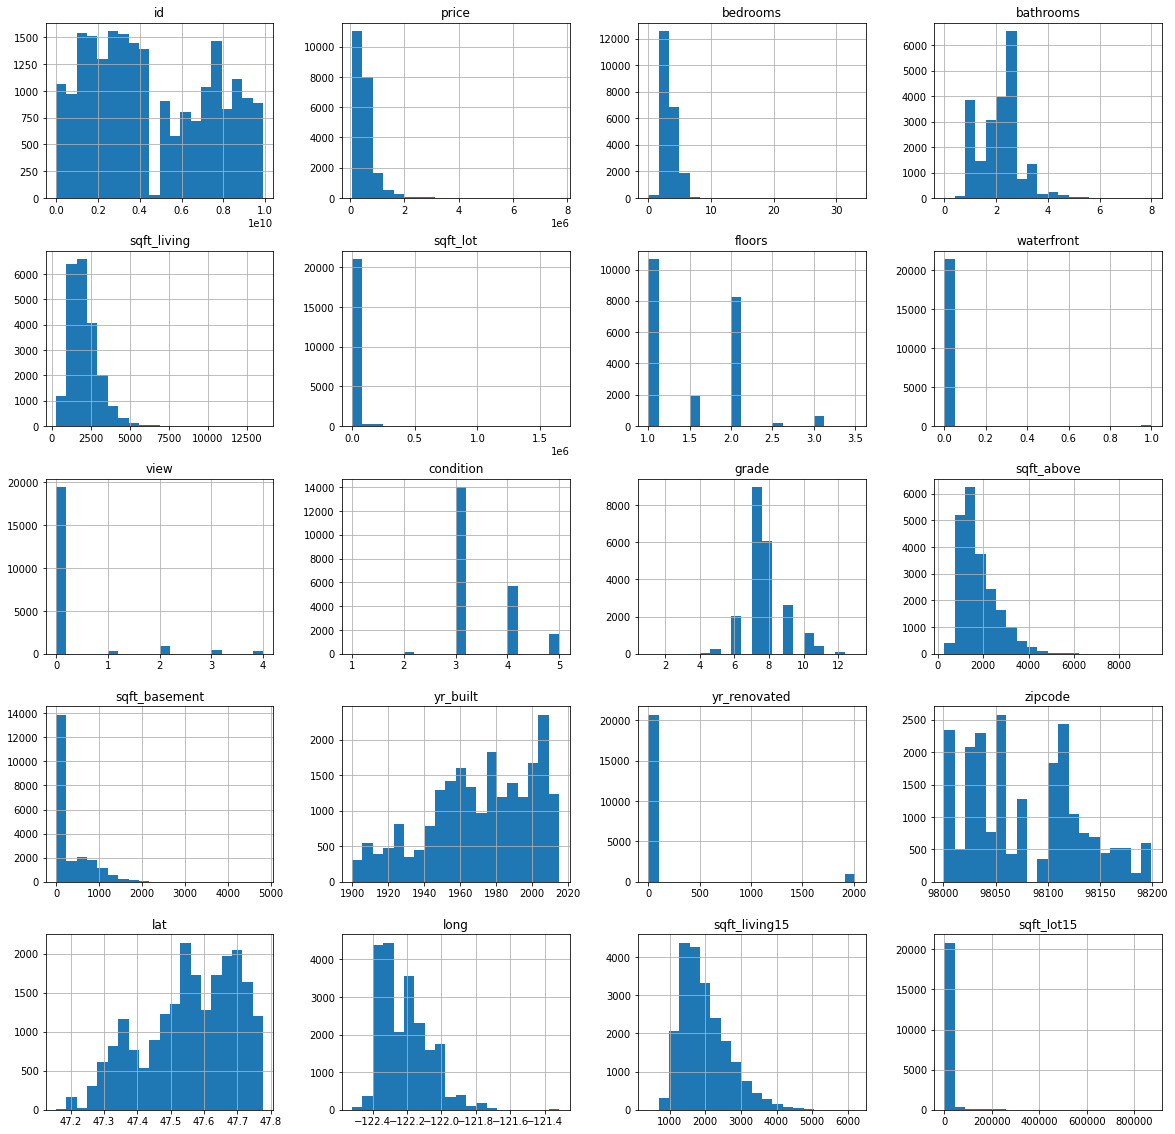

In [ ]:
house_df.hist(bins=20, figsize=(20, 20))
plt.show()

## Data Preprocessing

We select only features that are useful (deleting 'id' and 'date'), not redundant (deleting all but one square footage variable) and with at least 0.20 correlation with the response variable.

We will also apply a natural log transform to the response variable to remove its skewness. Note that this type of transform is only applicable when the original data follows a log-normal distribution.

As we are using least squares linear regression, normalizing predictors will not help the model. Nonetheless, normalizing predictors would be useful if we were trying to interpret model coefficients.

In [ ]:
# Select only the most useful predictor variables.
high_corr_variables = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
                       'waterfront', 'view', 'grade', 'lat']

X = house_df[high_corr_variables]

# Apply natural log transform to response variable to remove skewness.
y = np.log(house_df['price'])
X

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,lat
0,3,1.00,1180,1.0,0,0,7,47.5112
1,3,2.25,2570,2.0,0,0,7,47.7210
2,2,1.00,770,1.0,0,0,6,47.7379
3,4,3.00,1960,1.0,0,0,7,47.5208
4,3,2.00,1680,1.0,0,0,8,47.6168
...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,3.0,0,0,8,47.6993
21609,4,2.50,2310,2.0,0,0,8,47.5107
21610,2,0.75,1020,2.0,0,0,7,47.5944
21611,3,2.50,1600,2.0,0,0,8,47.5345


We split the data between train and test sets. Data is rescaled to make the model train faster. Feature normalization is not necessary since we are working with least squares linear regression.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Building and Training

In our training session, we started with a model with 2 hidden layers, as this amount is known for being sufficient to adjust to any practical problem. However, adding another 2 hidden layers reduced errors, reason why 4 hidden layers are used.

The only logic used when choosing the number of neurons per layer is to keep reducing from input layer until the last layer. Last layer has a single neuron and a linear activation function since this is a regressor. Remaining layers use ReLU activation function.

In [ ]:
neural_regressor = tf.keras.models.Sequential()
neural_regressor.add(tf.keras.layers.Dense(units=6, activation='relu',
                                           input_shape=(8,)))
neural_regressor.add(tf.keras.layers.Dense(units=4, activation='relu'))
neural_regressor.add(tf.keras.layers.Dense(units=3, activation='relu'))

# Linear activation function in the last layer as this is a regressor.
neural_regressor.add(tf.keras.layers.Dense(units=1, activation='linear'))
neural_regressor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 6)                 54        
                                                                 
 dense_29 (Dense)            (None, 4)                 28        
                                                                 
 dense_30 (Dense)            (None, 3)                 15        
                                                                 
 dense_31 (Dense)            (None, 1)                 4         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Training hyperparameters, such as patience for early stopping and learning rate reducer, batch size and number of epochs are empirically defined.

Starting learning rate is 0.01 so we can converge faster while making use of our learning rate reducer.

In [ ]:
# Patience for our callbacks are empirically defined.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=5)

# 20 batches are used in training.
batch_size = X_train.shape[0] // 20

# High learning rate for faster convergence. Batch size set to 1000 to
# let the model train as needed before early stopping is triggered.
neural_regressor.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                         loss='mse')
epochs_info = neural_regressor.fit(X_train, 
                                   y_train,
                                   batch_size=batch_size,
                                   epochs=1000,
                                   validation_split=0.15,
                                   callbacks=[early_stopping_callback,
                                              reduce_lr_callback])

Epoch 1/1000
18/18 [==============================] - 1s 11ms/step - loss: 167.7874 - val_loss: 161.2727 - lr: 0.0100
Epoch 2/1000
18/18 [==============================] - 0s 5ms/step - loss: 147.0090 - val_loss: 116.1706 - lr: 0.0100
Epoch 3/1000
18/18 [==============================] - 0s 5ms/step - loss: 71.0219 - val_loss: 12.9153 - lr: 0.0100
Epoch 4/1000
18/18 [==============================] - 0s 5ms/step - loss: 6.3933 - val_loss: 4.4023 - lr: 0.0100
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.5411 - val_loss: 2.2840 - lr: 0.0100
Epoch 6/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.9146 - val_loss: 1.7936 - lr: 0.0100
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.6569 - val_loss: 1.5609 - lr: 0.0100
Epoch 8/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5153 - val_loss: 1.4418 - lr: 0.0100
Epoch 9/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.4047 - va

We have tested training our model without removing skewness from the response variable. That led to a much slower convergion with the gradient being stuck in local minimas and overall progressing slower.

In the plot below we can see that our regressor converges very fast and reaches a very small loss value. This indicates that the model has learned everything available on the training data.

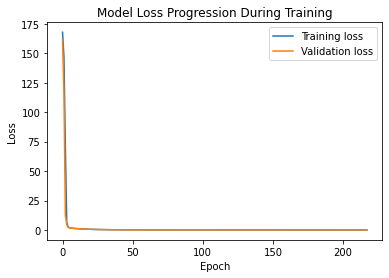

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

## Model Evaluation

We start evaluating our model by observing a plot with predicted versus actual house prices. Ideal case happens when there is a diagonal line crossing the plot, meaning that there is zero error for every prediction.

We can see that the points are very spread, even though they are forming a linear correlation. There is a significant amount of error in our predictions.

Another thing to note is that the points are forming a slightly exponential-shaped curve. This is an indication that house prices have exponential behavior. Our regression curve, being linear, is not able to represent that and errors start getting more clustered to the upper side of the diagonal. Actual prices grow faster than our linearly regressed predicted prices.

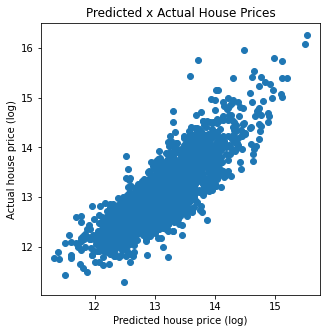

In [ ]:
y_pred = neural_regressor.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred)
plt.title("Predicted x Actual House Prices")
plt.xlabel("Predicted house price (log)")
plt.ylabel("Actual house price (log)")
plt.show()

The plot below shows a predicted prices curve and an actual prices curve against a subsample of our data. We can see that our model is able to follow the actual prices curve, but missing some spikes.

These type of errors are another indication that our model is not able to capture the exponential growth of prices. It fails to correctly hit prices that are higher.

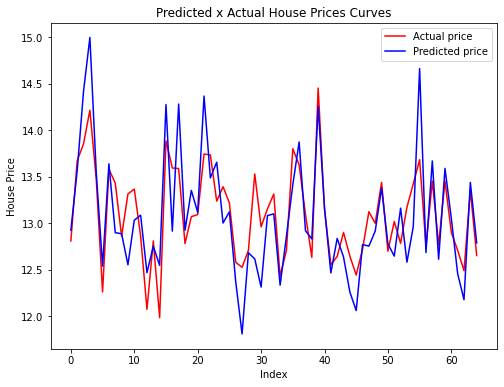

In [ ]:
count = np.arange(0, len(y_test) / 50)

plt.figure(figsize=(8, 6))
plt.title("Predicted x Actual House Prices Curves")
plt.plot(count, y_test[:len(count)], color='r')
plt.plot(count, y_pred[:len(count)], color='b')
plt.xlabel("Index")
plt.ylabel("House Price")
plt.legend(['Actual price', 'Predicted price'])
plt.show()

Lastly, we can check the usual error metrics used to evaluate regression models. R2 score is at 0.64, which is not bad, but far from great. Other metrics (MAE, MSE and RMSE) are more useful when comparing models.

We saw that our final validation losses were very small and stable, meaning that the model learned everything it could from the data. There are strong indications in our results that a linear regression model has limitations trying to represent the behavior of this dataset.

Polynomial features transformation using the selected features would certainly improve the model's capacity, but that would not be a linear regression anymore. Other non-linear models will probably perform better on this data.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Take dimensions from the test set and calculate the adjusted R2 score.
n = X_test.shape[0]
k = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("R2 score: ", r2)
print("Adjusted R2 score: ", adjusted_r2)

Mean Absolute Error:  0.2486332030010165
Mean Squared Error:  0.1049752125110505
Root Mean Squared Error:  0.32399878473699634
R2 score:  0.6359491089017966
Adjusted R2 score:  0.6350482715591471


## Neural Regressor on Full House Dataset

Next, we repeat the same steps performed using a filtered dataset, but now with the full dataset. The objective here is to confirm that we did not discard any useful features while filtering. 

Another difference is the number of neurons, that was adjusted as we are dealing with more features.

In [ ]:
X = house_df.drop(['id', 'date', 'price'], axis=1)
y = np.log(house_df['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
neural_regressor = tf.keras.models.Sequential()
neural_regressor.add(tf.keras.layers.Dense(units=10, activation='relu',
                                           input_shape=(18,)))
neural_regressor.add(tf.keras.layers.Dense(units=6, activation='relu'))
neural_regressor.add(tf.keras.layers.Dense(units=4, activation='relu'))
neural_regressor.add(tf.keras.layers.Dense(units=1, activation='linear'))

neural_regressor.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 10)                190       
                                                                 
 dense_49 (Dense)            (None, 6)                 66        
                                                                 
 dense_50 (Dense)            (None, 4)                 28        
                                                                 
 dense_51 (Dense)            (None, 1)                 5         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=5)

batch_size = X_train.shape[0] // 20

neural_regressor.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                         loss='mse')
epochs_info = neural_regressor.fit(X_train,
                                   y_train,
                                   batch_size=batch_size,
                                   epochs=1000,
                                   validation_split=0.15,
                                   callbacks=[early_stopping_callback,
                                              reduce_lr_callback])

Epoch 1/1000
18/18 [==============================] - 1s 11ms/step - loss: 165.8876 - val_loss: 155.9049 - lr: 0.0100
Epoch 2/1000
18/18 [==============================] - 0s 5ms/step - loss: 133.9156 - val_loss: 89.4564 - lr: 0.0100
Epoch 3/1000
18/18 [==============================] - 0s 5ms/step - loss: 38.6455 - val_loss: 4.1048 - lr: 0.0100
Epoch 4/1000
18/18 [==============================] - 0s 6ms/step - loss: 6.1384 - val_loss: 2.5274 - lr: 0.0100
Epoch 5/1000
18/18 [==============================] - 0s 5ms/step - loss: 2.6541 - val_loss: 1.9409 - lr: 0.0100
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.8973 - val_loss: 1.7169 - lr: 0.0100
Epoch 7/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.6505 - val_loss: 1.5600 - lr: 0.0100
Epoch 8/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.4919 - val_loss: 1.4113 - lr: 0.0100
Epoch 9/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.3602 - val_

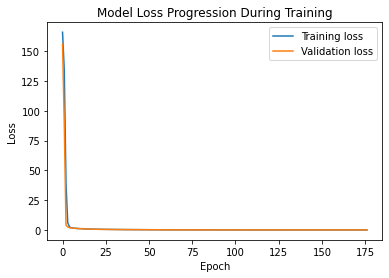

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

We see another curve shape being formed by the points in the plot below, instead of a diagonal shape. Again indicating that there is an exponential behavior in the data that our linear model will not be able to capture.

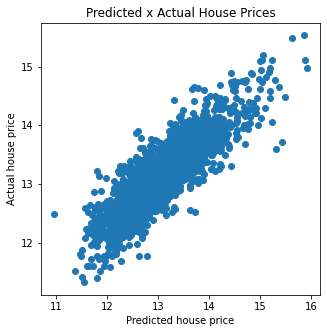

In [ ]:
y_pred = neural_regressor.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_pred, y_test)
plt.title("Predicted x Actual House Prices")
plt.xlabel("Predicted house price")
plt.ylabel("Actual house price")
plt.show()

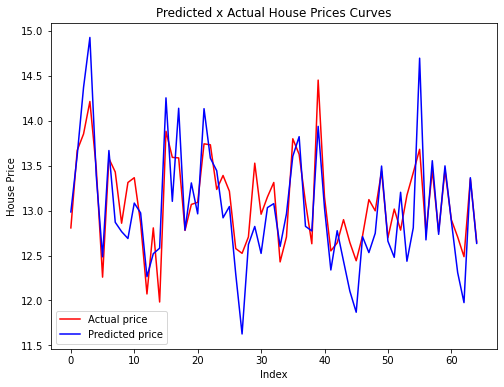

In [ ]:
count = np.arange(0, len(y_test) / 50)

plt.figure(figsize=(8, 6))
plt.title("Predicted x Actual House Prices Curves")
plt.plot(count, y_test[:len(count)], color='r')
plt.plot(count, y_pred[:len(count)], color='b')
plt.xlabel("Index")
plt.ylabel("House Price")
plt.legend(['Actual price', 'Predicted price'])
plt.show()

Finally, we can see that the adjusted R2 score for this second model is slightly smaller than the one from the first model.

It is important to consider the adjusted R2 score because R2 score increases as more data variance gets represented by the model coefficients. In other words, by adding more features, R2 score will increase anyway. Adjusted R2 score accounts for that by checking if the added features really contribute in performance.

Remaining evalution metrics also show that the first model is slightly better than this last one. However, differences are close to negligible.

Nonetheless, filtering some features out as we did is important. Linear regression assumes that there is no multicollinearity between predictors. With high correlation between predictor features being avoided, we have more guarantees that this model can be used in production without creating unexpected behaviors.

The conclusion that we can make here is that linear regression is able to represent this dataset with limitations. If more accurate predictions are needed, a more complex model should be employed.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

n = X_test.shape[0]
k = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("R2 score: ", r2)
print("Adjusted R2 score: ", adjusted_r2)

Mean Absolute Error:  0.2557768984406862
Mean Squared Error:  0.10778705641016559
Root Mean Squared Error:  0.3283093912914548
R2 score:  0.6261977185248147
Adjusted R2 score:  0.624110085553498
